In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

______________________________

In [79]:
network = 'tarbase'
target_homology = 'mix'
remove_pre_2R = False

In [80]:
if target_homology == 'wgd':
	file_path_1 = f'./output/{network}_om.z_1000.tsv'
	file_path_2 = f'./output/{network}_pm_mixed.z_1000.tsv'
elif target_homology == 'ssd':
	file_path_1 = f'./output/{network}_om_mixed.z_1000.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.tsv'
elif target_homology == 'mix':
	file_path_1 = f'./output/{network}_om.z_1000.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.tsv'
else:
	raise ValueError("target_homology must be either 'wgd', 'ssd' or 'mix'")

df_1 = pd.read_csv(file_path_1, sep='\t', header=0)
df_2 = pd.read_csv(file_path_2, sep='\t', header=0)

In [81]:
mirna_origin_file_path = '../../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirna_origin = df_mirna_origin[[8, 14, 15]]
df_mirna_origin = df_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirna_origin.columns = cols
df_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

# test the dict
mirna_lno_dict['MIRLET7E'][0]

'Bilateria'

In [82]:
df_wgd = df_1
df_ssd = df_2

In [83]:
print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  113
Number of SSD pairs:  1383


In [84]:
pre_2R_clades = ['Bilateria', 'Chordata', 'Eumetazoa', 'Vertebrata', 'Nephrozoa', 'Olphactores']

def all_clades_in_pre2R(mirna):
    clades = mirna_lno_dict.get(mirna, [])
    return all(clade in pre_2R_clades for clade in clades)

if remove_pre_2R:
	df_ssd = df_ssd[~(df_ssd["miRNA_1"].apply(all_clades_in_pre2R) & df_ssd["miRNA_2"].apply(all_clades_in_pre2R))]

print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  113
Number of SSD pairs:  1383


In [85]:
def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA_1']
		mirna2 = row['miRNA_2']
		if mirna1 != mirna2:
			mirna_pairs.add(tuple(sorted([mirna1, mirna2])))

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA_1'], row['miRNA_2']])) in mirna_pairs, axis=1)]
	
	return filtered_df

df_ssd = remove_mirna_pairs(df_ssd, df_wgd)

In [86]:
print("Number of WGD pairs after removing miRNA pairs: ", len(df_wgd))
print("Number of SSD pairs after removing miRNA pairs: ", len(df_ssd))

Number of WGD pairs after removing miRNA pairs:  113
Number of SSD pairs after removing miRNA pairs:  1271


In [87]:
# if the column Z-score is equal to "sigma_err" and the column "n_relevant_bifan" is equal to 0, then the Z-score is equal to 0
def remove_sigma_err(df):
    # Step 1: Set Z-score to 0 if Z-score == 'sigma_err' and n_relevant_bifan == 0
    mask_fix = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] == 0)
    df.loc[mask_fix, 'Z-score'] = 0

    # Step 2: Remove rows where Z-score == 'sigma_err' and n_relevant_bifan != 0
    mask_remove = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] != 0)
    df = df[~mask_remove]

    return df

df_wgd = remove_sigma_err(df_wgd)
df_ssd = remove_sigma_err(df_ssd)

In [88]:
df_wgd_zscores = df_wgd['Z-score'].astype(float)
df_ssd_zscores = df_ssd['Z-score'].astype(float)

In [89]:
df_wgd_nbifan = df_wgd['n_relevant_bifan'].astype(int)
df_ssd_nbifan = df_ssd['n_relevant_bifan'].astype(int)

In [90]:
n_wgd = len(df_wgd_zscores)
n_ssd = len(df_ssd_zscores)

print("n_wgd in the boxplot: ", n_wgd)
print("n_ssd in the boxplot: ", n_ssd)

n_wgd in the boxplot:  113
n_ssd in the boxplot:  1262


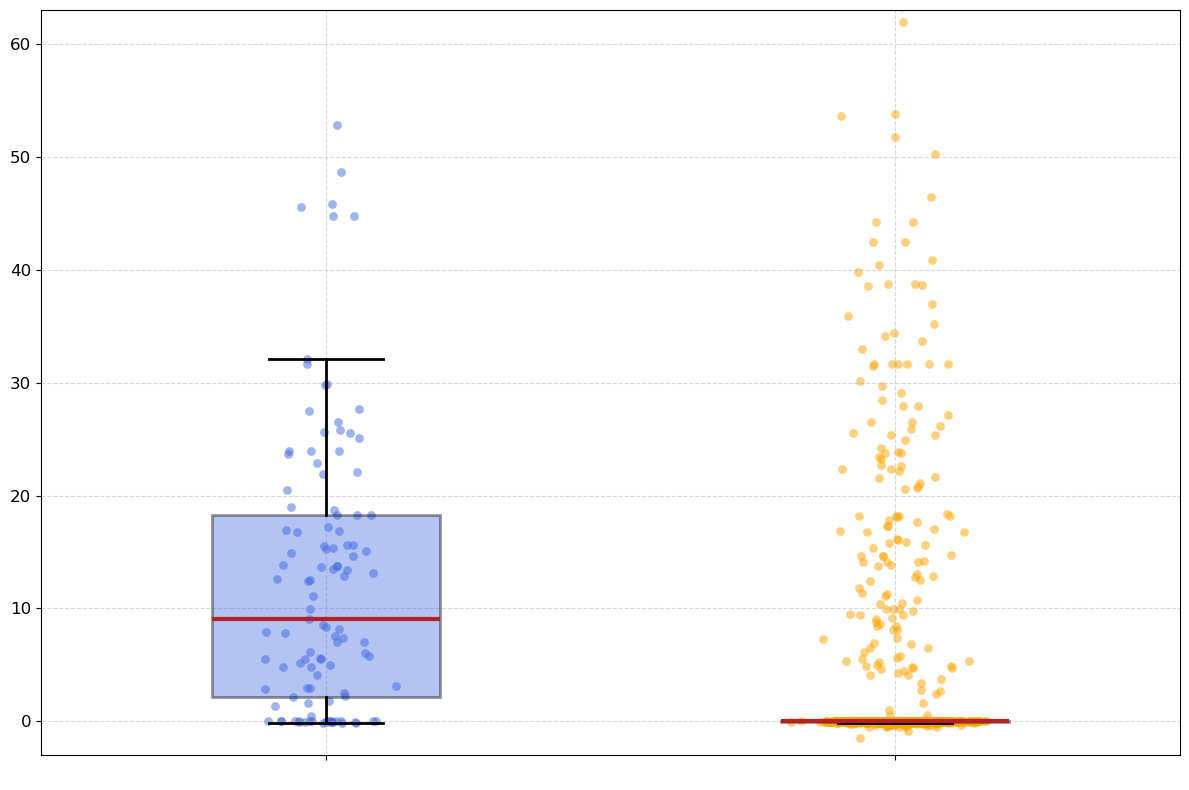

In [91]:
data = [df_wgd_zscores, df_ssd_zscores]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['', ''][i])

plt.xticks(positions, [' ', ' '], fontsize=100)
plt.ylim(-3, 63)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'../../local/pictures/{network}_{target_homology}_bifan_boxplot_zscores_mgdbSSD.png', dpi=300)
plt.show()

In [92]:
ks_stat, ks_p_value = stats.ks_2samp(df_wgd_zscores, df_ssd_zscores)
print(f"KS statistic: {ks_stat}, p-value: {ks_p_value}")

KS statistic: 0.6592429491045257, p-value: 2.9858422930793804e-44


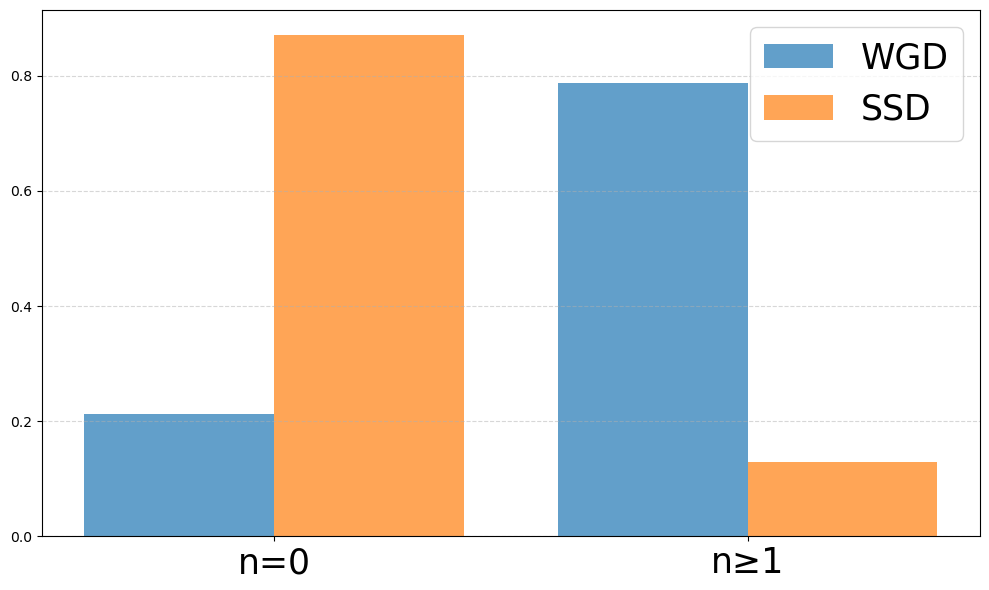

In [93]:
labels = ['n=0', 'n≥1']

def bin_bifans(count):
    if count == 0:
        return labels[0]
    else:
        return labels[1]

# Bin the counts
wgd_binned = pd.Series(df_wgd_nbifan).apply(bin_bifans)
ssd_binned = pd.Series(df_ssd_nbifan).apply(bin_bifans)

# Get relative frequencies for each bin
wgd_freq = wgd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)
ssd_freq = ssd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)

x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wgd_freq, width=width, label='WGD', alpha=0.7)
plt.bar(x + width/2, ssd_freq, width=width, label='SSD', alpha=0.7)

plt.xticks(x, labels, fontsize=25)
plt.xlabel('')
plt.title('')
plt.legend(fontsize=25)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f'../../local/pictures/{network}_{target_homology}_bifan_barplot_zscores_mgdbSSD.png', dpi=300)
plt.show()

In [94]:
# print the SSD pairs with Z-score > 3
df_ssd_high_z = df_ssd[df_ssd['Z-score'].astype(float) > 1]
df_ssd_high_z

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000)
0,MIR100,MIR10A,136,272,7,0.039,0.203664,1,37,4.71855746916284,7.278364577700813e-10
8,MIR10A,MIR125A,272,306,22,0.172,0.445439,2,19,4.103815678209253,1.0872784996784901e-06
13,MIR10B,MIR125A,141,306,18,0.046,0.214206,1,45,4.453666973119295,1.6518442169655145e-09
36,MIR106A,MIR20A,538,927,299,4.049,2.451652,40,0,14.663988037897942,2.2870499987615034e-05
37,MIR106A,MIR20B,538,366,201,0.787,1.007785,19,0,18.072303585860436,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1377,MIRLET7F1,MIRLET7F2,543,519,488,1.557,1.458338,66,0,44.18933103386135,0.0
1378,MIRLET7F1,MIRLET7G,543,620,453,2.101,1.781797,55,0,29.688574459705773,0.0
1379,MIRLET7F1,MIRLET7I,543,478,436,1.325,1.313535,55,0,40.86300517124271,0.0
1380,MIRLET7F2,MIRLET7G,519,620,453,1.929,1.585547,56,0,34.102428442800985,0.0


In [95]:
df_wgd_high_z = df_wgd[df_wgd['Z-score'].astype(float) > 3]
df_wgd_high_z

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000)
1,MIR103A1,MIR103A2,950,1075,950,2.990,1.744104,33,0,17.20653923003011,3.394947e-09
2,MIR103A1,MIR107,950,959,927,2.576,1.635917,30,0,16.763688015784837,2.413952e-09
3,MIR103A2,MIR107,1075,959,930,3.009,1.730005,30,0,15.60168458158699,1.290864e-07
4,MIR106A,MIR106B,538,398,205,0.214,0.456294,3,0,6.105715689216075,3.382723e-09
5,MIR106A,MIR17,538,1373,308,1.649,1.312173,9,0,5.602155986091695,6.950639e-03
...,...,...,...,...,...,...,...,...,...,...,...
106,MIRLET7B,MIRLET7F1,599,543,456,0.465,0.686130,13,0,18.269120581480326,0.000000e+00
107,MIRLET7A2,MIRLET7C,926,328,303,0.368,0.620142,6,0,9.0817921273447,8.987255e-12
108,MIRLET7A2,MIRLET7E,926,355,262,0.486,0.744180,5,1,6.065736085318966,8.317223e-07
109,MIRLET7C,MIRLET7E,328,355,247,0.085,0.289439,5,0,16.981118940678478,0.000000e+00
